# 적대적 생성 신경망으로 NMIST이미지를 생성

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

In [2]:
# 실험을 재현하고 동일한 결과를 얻을 수 있는지 확인하기 위해 seed 를 설정합니다.
np.random.seed(10)

# 우리의 랜덤 노이즈 벡터의 차원을 설정합니다.
random_dim = 100

In [3]:
# 데이터를 로드합니다.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 데이터를 -1 ~ 1 사이 값으로 normalize 합니다.
x_train = (x_train.astype(np.float32) - 127.5)/127.5

# x_train 의 shape 를 (60000, 28, 28) 에서 (60000, 784) 로 바꿉니다.
# 따라서 우리는 한 row 당 784 columns 을 가지게 됩니다.
x_train = x_train.reshape(60000, 784)

이제 Generator 및 Discriminatora 네트워크를 만들어 볼 수 있습니다. 두 네트워크에 모두 Adam Optimizer를 사용합니다. Generator와 Discriminator의 경우 모두 세 개의 숨겨진 레이어가 있는 신경 네트워크를 생성하며 activation function(활성 함수)은 Leaky Relu를 사용합니다. 또한 Discriminator가 보이지 않는 영상에서 견고성을 향상시킬 수 있도록 Dropout(드롭아웃) 레이어를 추가해야 합니다.

## 생성자

먼저 벡터(훈련하는 동안 잠재 공간에서 무작위로 샘플링됩니다)를 후보 이미지로 변환하는 `generator` 모델을 만들어 보죠. GAN에서 발생하는 많은 문제 중 하나는 생성자가 노이즈 같은 이미지를 생성하는 데서 멈추는 것입니다. 판별자와 생성자 양쪽에 모두 드롭아웃을 사용하는 것이 해결 방법이 될 수 있습니다.

In [5]:
# Generator 만들기
generator = Sequential()
generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))

generator.add(Dense(512))
generator.add(LeakyReLU(0.2))

generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))

generator.add(Dense(784, activation='tanh'))
generator.summary()
generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

## 판별자

다음은 후보 이미지(진짜 혹은 가짜)를 입력으로 받고 두 개의 클래스로 분류하는 `discriminator` 모델을 만들겠습니다. 이 클래스는 '생성된 이미지' 또는 '훈련 세트에서 온 진짜 이미지'입니다.

In [6]:
# Discriminator 만들기
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

discriminator.add(Dense(1, activation='sigmoid'))
discriminator.summary()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

## 적대적 네트워크

마지막으로 생성자와 판별자를 연결하여 GAN을 설정합니다. 훈련할 때 생성자가 판별자를 속이는 능력이 커지도록 학습합니다. 이 모델은 잠재 공간의 포인트를 “진짜" 또는 “가짜"의 분류 결정으로 변환합니다. 훈련에 사용되는 타깃 레이블은 항상 '진짜 이미지'입니다. `gan`을 훈련하는 것은 `discriminator`가 가짜 이미지를 보았을 때 진짜라고 예측하도록 만들기 위해 `generator`의 가중치를 업데이트하는 것입니다. 훈련하는 동안 판별자를 동결(학습되지 않도록)하는 것이 아주 중요합니다. `gan`을 훈련할 때 가중치가 업데이트되지 않습니다. 판별자의 가중치가 훈련하는 동안 업데이트되면 판별자는 항상 “진짜"를 예측하도록 훈련됩니다. 이것이 우리가 원하는 바는 아니죠!

In [7]:
# 판별자의 가중치가 훈련되지 않도록 설정합니다(gan 모델에만 적용됩니다)
discriminator.trainable = False

# GAN 입력(노이즈)은 위에서 100 차원으로 설정했습니다.
gan_input = Input(shape=(random_dim,))

# Generator의 결과는 이미지 입니다.
x = generator(gan_input)

# Discriminator의 결과는 이미지가 진짜인지 가짜인지에 대한 확률입니다.
gan_output = discriminator(x)

gan = Model(inputs=gan_input, outputs=gan_output)
gan.summary()
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1486352   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


이제 네트워크의 대부분을 코딩했습니다. 남은 것은 이 네트워크를 훈련하고 당신이 만든 이미지를 보는 것입니다.

In [9]:
batch_size = 128
epochs = 3
# train 데이터를 128 사이즈의 batch 로 나눕니다.
batch_count = x_train.shape[0] // batch_size

In [10]:
# 훈련 반복 시작
for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15)
    for _ in tqdm(range(batch_count)):
        # 입력으로 사용할 random 노이즈와 이미지를 가져옵니다.
        noise = np.random.normal(0, 1, size=[batch_size, random_dim])

        image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

        # MNIST 이미지를 생성합니다.
        generated_images = generator.predict(noise)
        # 진짜 이미지와 연결합니다
        X = np.concatenate([image_batch, generated_images])

        y_dis = np.zeros(2*batch_size)
        y_dis[:batch_size] = 0.9

        # Discriminator를 학습시킵니다.
        discriminator.trainable = True
        discriminator.train_on_batch(X, y_dis)

        # Generator를 학습시킵니다.
        noise = np.random.normal(0, 1, size=[batch_size, random_dim])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        gan.train_on_batch(noise, y_gen)

  0%|                                                                             | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  0%|                                                                             | 0/468 [00:00<?, ?it/s]

--------------- Epoch 2 ---------------


  0%|                                                                             | 0/468 [00:00<?, ?it/s]

--------------- Epoch 3 ---------------


100%|███████████████████████████████████████████████████████████████████| 468/468 [01:42<00:00,  4.57it/s]


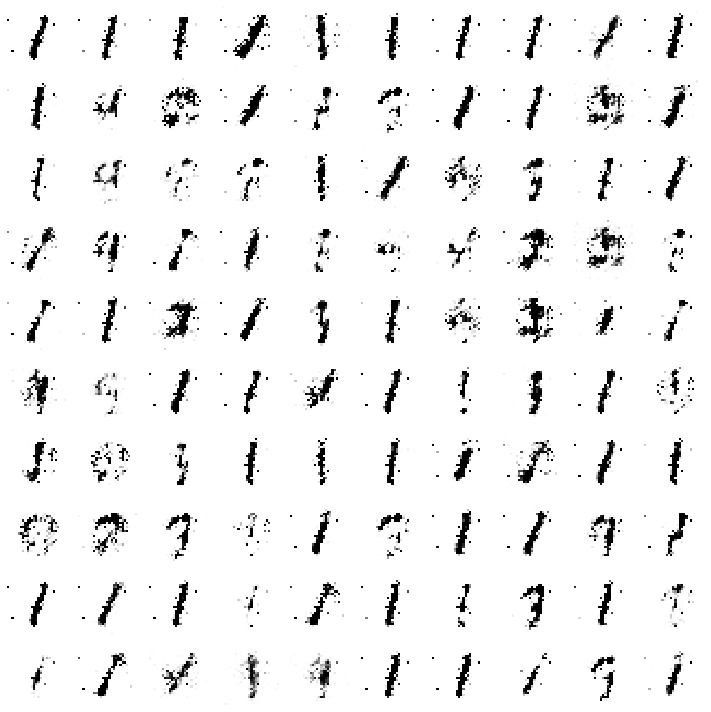

In [14]:
# 100개의 이미지를 생성합니다.
noise = np.random.normal(0, 1, size=[100, random_dim])
generated_images = generator.predict(noise)
generated_images = generated_images.reshape(100, 28, 28)

plt.figure(figsize=(10, 10))
for i in range(generated_images.shape[0]):
    plt.subplot(10, 10, i+1)
    plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.savefig('gan_generated_image.png')

400 epochs를 학습한 후 생성된 이미지를 보세요. 1 epoch 이후에 생성된 영상을 보면, 실제 구조가 없다는 것을 알 수 있습니다. 하지만 40 epochs 이후의 이미지를 보면, 숫자가 형성되기 시작하고 마지막으로, 400 epochs 후에 생성된 영상은 숫자가 뚜렷하게 나타납니다.